In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from Functions import *

In [4]:
pos = pd.read_csv('D:\\DSEB 63 - NEU\\Năm BA\\Visualization\\Data\\Data\\dseb63_final_project_DP_dataset\\dseb63_POS_CASH_balance.csv')

In [5]:
pos.head()

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,1803195,-31,48.0,45.0,Active,0,0,185279
1,1803195,-17,48.0,31.0,Active,0,0,185279
2,1803195,-21,48.0,35.0,Active,0,0,185279
3,1803195,-8,48.0,21.0,Active,0,0,185279
4,1803195,-4,48.0,17.0,Active,0,0,185279


# Pre check overall Dataframe

In [6]:
pos_check = pre_check_tool(pos)
pos_check.split_data()

In [7]:
# Check null percent
pos_check.check_per_null()

,number_missing,percent_missing
CNT_INSTALMENT_FUTURE,21878,0.256081
CNT_INSTALMENT,21863,0.255906


In [8]:
# find cols that have null > 90%
print(pos_check.find_null_cols(0.9))

Index([], dtype='object')


NO COLUMNS HAVE NULL VALUES > 90% -> SO WE'RE KEEPING THE DATASET AS IT IS FOR NOW

In [9]:
#duplicate check
pos.duplicated().sum()

0

In [10]:
# valid value
## Num data
pos_check.check_value_num()
print('\n\n\n')

## cat data
pos_check.check_value_cat()

SK_ID_PREV  has     >0 8543375,  =0 0  ,   <0 0,    nan: 0,   other values: 0
MONTHS_BALANCE  has     >0 0,  =0 0  ,   <0 8543375,    nan: 0,   other values: 0
CNT_INSTALMENT  has     >0 8521512,  =0 0  ,   <0 0,    nan: 21863,   other values: 0
CNT_INSTALMENT_FUTURE  has     >0 7499563,  =0 1021934  ,   <0 0,    nan: 21878,   other values: 0
SK_DPD  has     >0 259107,  =0 8284268  ,   <0 0,    nan: 0,   other values: 0
SK_DPD_DEF  has     >0 99110,  =0 8444265  ,   <0 0,    nan: 0,   other values: 0
SK_ID_CURR  has     >0 8543360,  =0 15  ,   <0 0,    nan: 0,   other values: 0




col NAME_CONTRACT_STATUS : ['Active', 'Completed', 'Approved', 'Signed', 'Returned to the store', 'Demand', 'XNA', 'Canceled', 'Amortized debt']



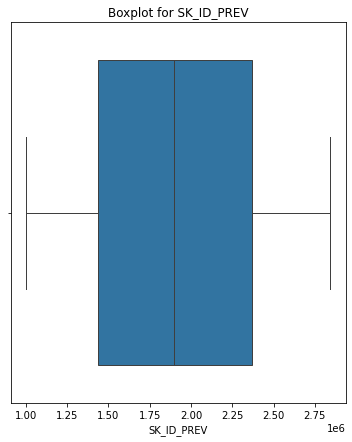

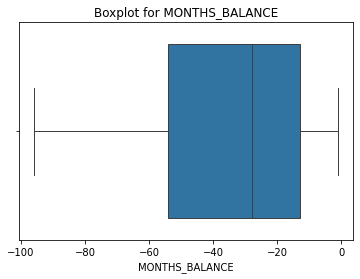

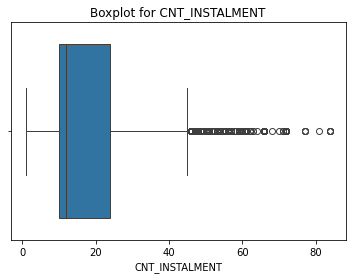

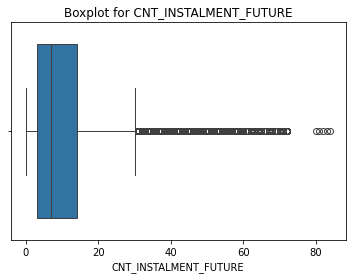

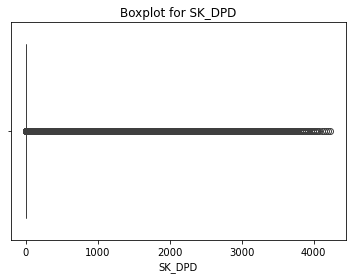

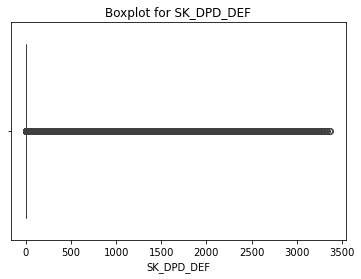

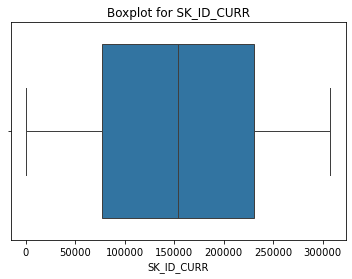

In [11]:
# Outliers 
pos_check.show_outliers()

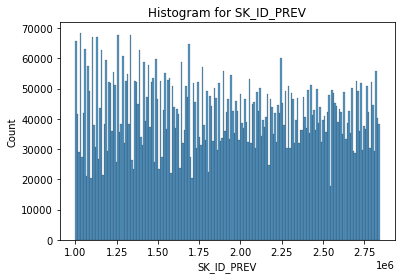

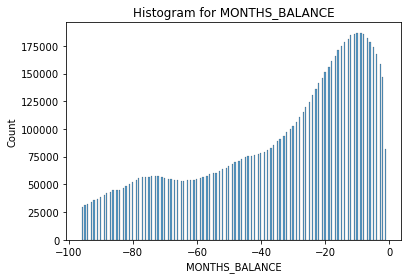

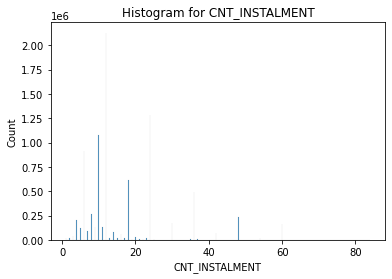

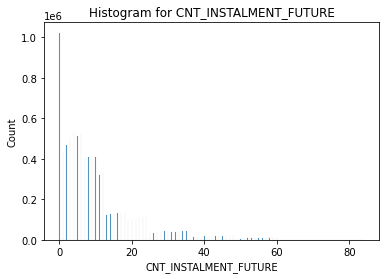

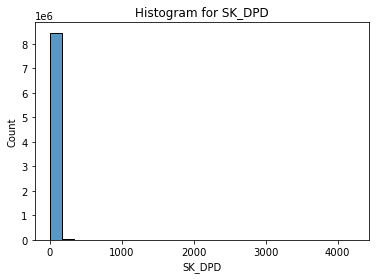

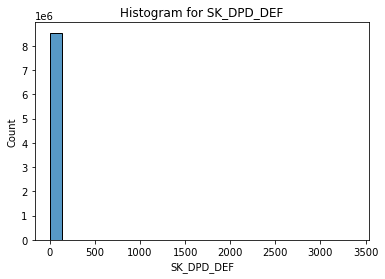

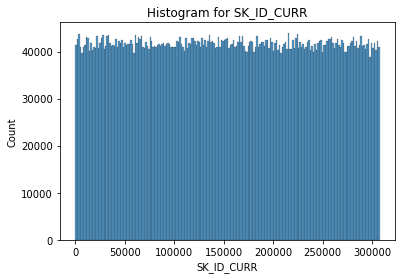

In [14]:
pos_check.dist_numchart()

# Data Exploration

# EDA Internal

In [15]:
# tao cot de kiem tra so lan bi qua han khi thanh toan khoan vay
def check_over_due(x):
    if x['SK_DPD'] > 0 and x['SK_DPD_DEF'] > 0:
        return 1
    else:
        return 0

pos['over_due'] =  pos.apply(check_over_due,axis= 1)

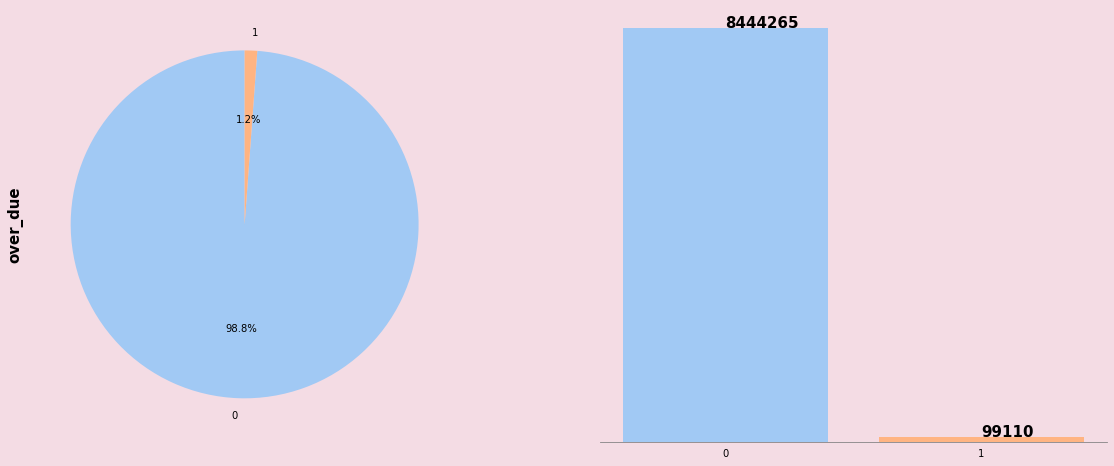

In [16]:
obj1 = Univariate_Analysis(df= pos, col= 'over_due', num= False)
obj1.visualize()

+ There are so many monthly payments that are paid on time with 98.8% 

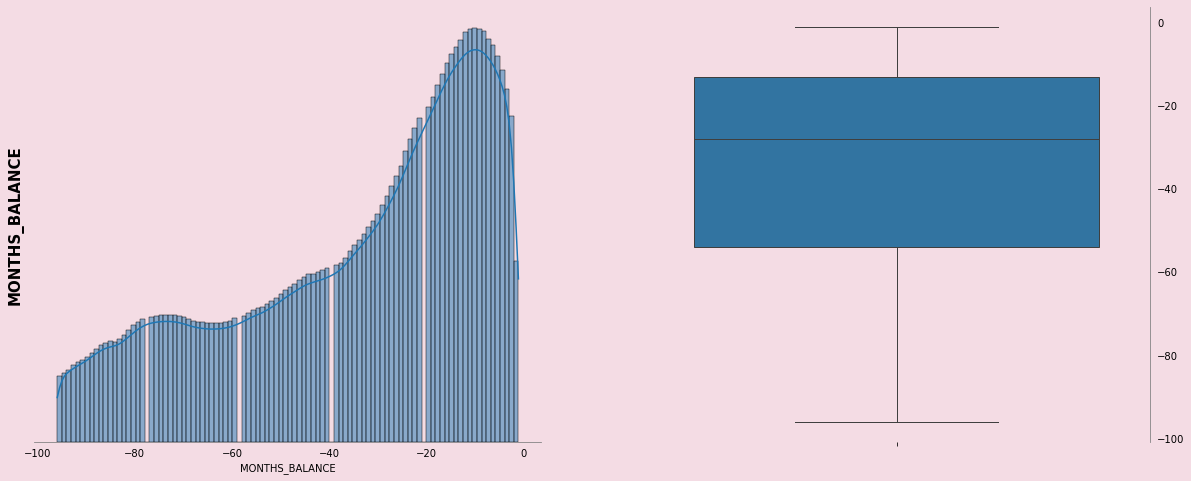

In [17]:
obj2 = Univariate_Analysis(df= pos , col= 'MONTHS_BALANCE', num= True)
obj2.visualize()

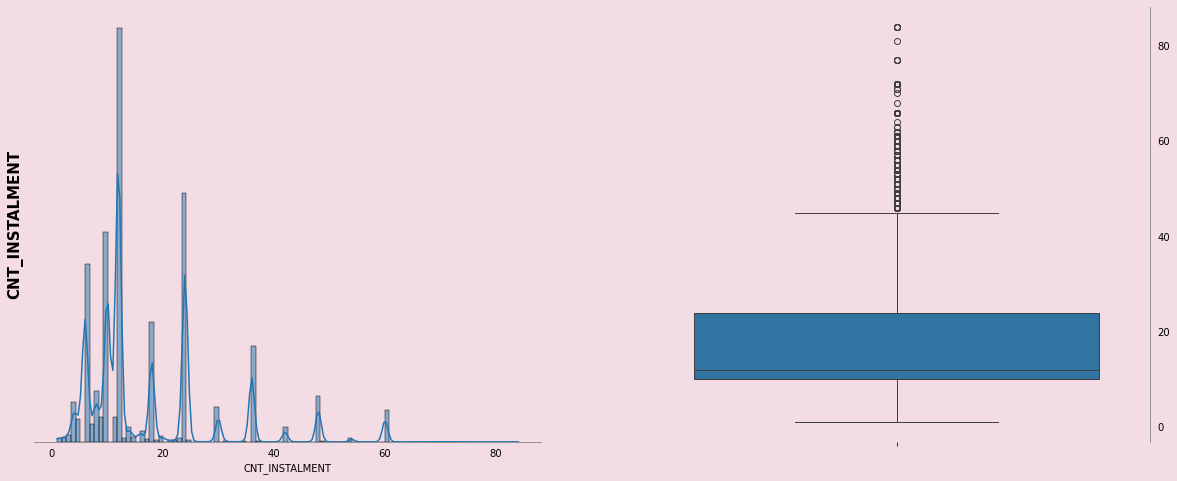

In [18]:
obj3 = Univariate_Analysis(df= pos , col= 'CNT_INSTALMENT', num= True)
obj3.visualize()

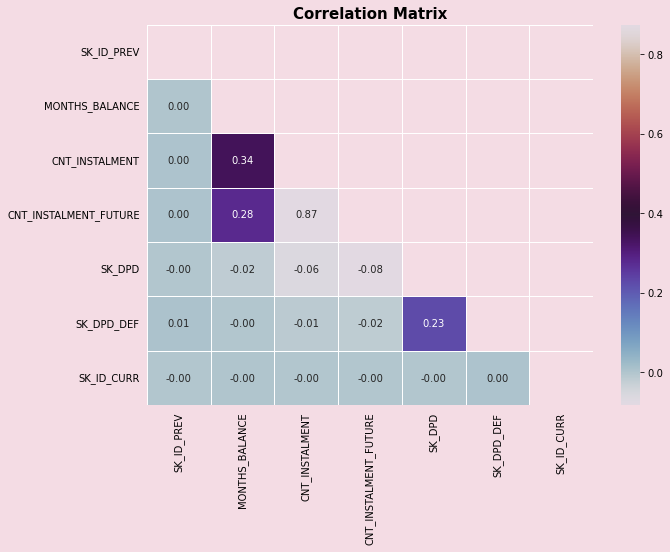

In [19]:
num = pos_check.numdf
# Correlation
draw_corr(num)

### Features that have high correlation: 
* CNT_INSTALMENT - CNT_INSTALMENT_FUTURE

# EDA External

In [20]:
file_train = 'D:\\DSEB 63 - NEU\\Năm BA\\Visualization\\Data\\Data\\dseb63_final_project_DP_dataset\\dseb63_application_train.csv'
app_train = pd.read_csv(file_train)
app_train = app_train[['SK_ID_CURR','TARGET']]

In [21]:
merge_table = pd.merge(pos,app_train,on='SK_ID_CURR',how='left')
merge_table.head()

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR,over_due,TARGET
0,1803195,-31,48.0,45.0,Active,0,0,185279,0,0.0
1,1803195,-17,48.0,31.0,Active,0,0,185279,0,0.0
2,1803195,-21,48.0,35.0,Active,0,0,185279,0,0.0
3,1803195,-8,48.0,21.0,Active,0,0,185279,0,0.0
4,1803195,-4,48.0,17.0,Active,0,0,185279,0,0.0


* Đây chính là thông tin cập nhật hàng tháng của các khoản vay POS, CASH theo từng tháng cho nên ta lấy thông tin cập nhật mới nhất theo từng tháng của từng SK_ID_PREV

In [22]:
pos_filter = merge_table.sort_values(by=['MONTHS_BALANCE']).groupby(["SK_ID_CURR", "SK_ID_PREV"]).last().reset_index()


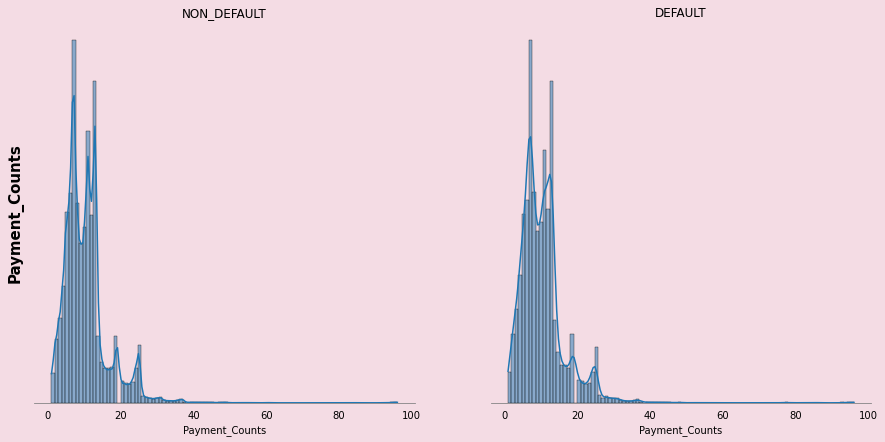

In [23]:
# so lan phải trả để cac khoan CASH, POS duoc thanh toan hoan tat
pos_filter['Payment_Counts'] = pos.sort_values(by=['MONTHS_BALANCE']).groupby(["SK_ID_CURR", "SK_ID_PREV"])['MONTHS_BALANCE']\
    .agg('count').reset_index()['MONTHS_BALANCE']
obj1 = Bivariate_Analysis(df = pos_filter, col1= 'Payment_Counts', num= True)
obj1.plothistogram()

* Almost the total payment in each loan is between 10 to 30 , but there are some extreme point with nearly 100 times payment.

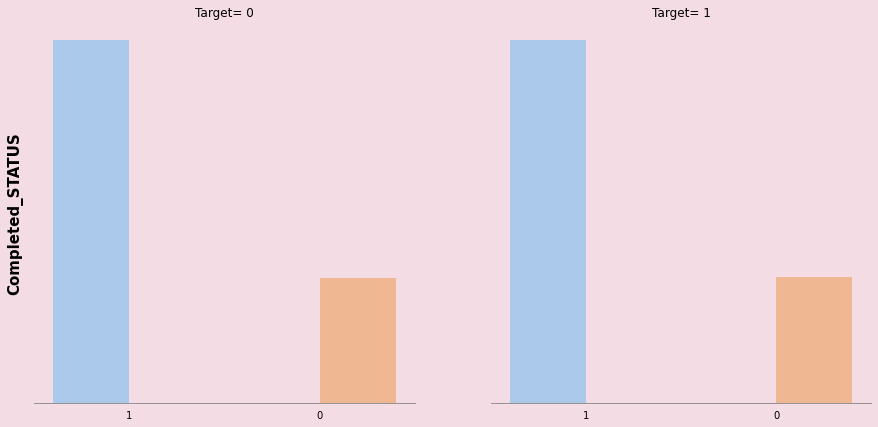

In [24]:
#kiem tra xem khoan vay do da duoc tra hoan tat hay chua (0 la chua, 1 la co)
pos_filter["Completed_STATUS"] = pos_filter["NAME_CONTRACT_STATUS"].apply(lambda x: 1 if x== "Completed" else 0)
pos_filter = pos_filter.drop(columns='NAME_CONTRACT_STATUS',axis = 1)
obj1 = Bivariate_Analysis(df = pos_filter, col1= 'Completed_STATUS', num= False)
obj1.countplot()

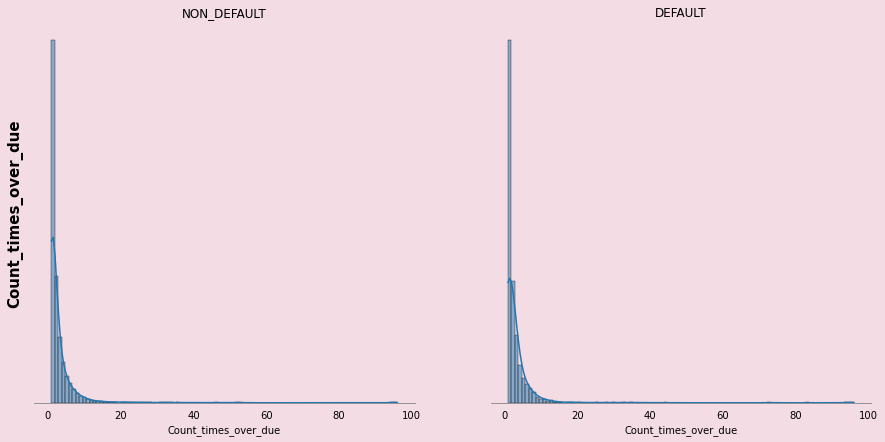

In [25]:
# dem xem trong 1 khoan vay ho nop tien muon bao nhieu lan

sk_dpd_count_overdue = pos[pos['SK_DPD'] > 0].sort_values(by=['MONTHS_BALANCE'])\
    .groupby(["SK_ID_CURR", "SK_ID_PREV"])['SK_DPD'].agg('count').reset_index()\
        .rename(columns={'SK_DPD':'Count_times_over_due'})

pos_filter = pd.merge(pos_filter, sk_dpd_count_overdue , on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')

obj1 = Bivariate_Analysis(df = pos_filter, col1= 'Count_times_over_due', num= True)
obj1.plothistogram()


* Hầu hết các khoản vay được trả khá là đúng hạn 